# **Google Play Store Apps** - Data Cleaning

This notebook includes the procedure of cleaning data with pandas methods on google play store apps data obtained from [Kaggle](https://www.kaggle.com/datasets/lava18/google-play-store-apps).

## 1) Import Libraries

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from IPython.display import display_html
from packaging.version import parse, Version, LegacyVersion
from packaging.utils import canonicalize_version
from itertools import islice
import os, re

## 2) Data Acquisition

Google play store apps data is acquired from [Kaggle](https://www.kaggle.com/datasets/lava18/google-play-store-apps) as two csv files *googleplaystore.csv* for app features and *googleplaystore_user_reviews.csv* for app reviews. We will load these datasets into two dataframes ***df_feature*** and ***df_review***.

#### Feature Data:

In [2]:
# load the feature data
# df_feature = pd.read_csv('data/googleplaystore.csv', na_values = ['NaN', 'Varies with device'])
df_feature = pd.read_csv('data/googleplaystore.csv')

# sample feature data
df_feature.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
# observe the new dataframe details
df_feature.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
# missing values, show only columns with some empty
df_feature.isna().sum().iloc[df_feature.isna().sum().to_numpy().nonzero()]

Rating            1474
Type                 1
Content Rating       1
Current Ver          8
Android Ver          3
dtype: int64

<AxesSubplot:>

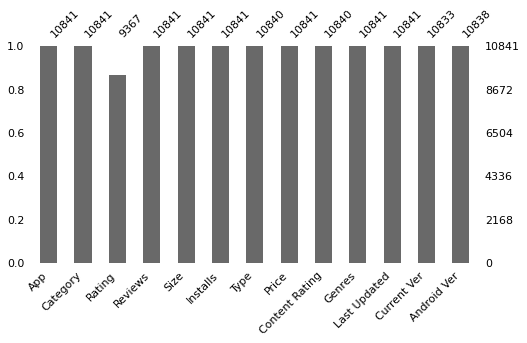

In [5]:
# missingno for features dataset, confirms the observations from previous cell
msno.bar(df_feature, figsize=(8, 4), fontsize=11)

#### Review Data:

In [6]:
# load the review data
# df_review = pd.read_csv('data/googleplaystore_user_reviews.csv', na_values = ['nan'])
df_review=pd.read_csv('data/googleplaystore_user_reviews.csv')

# sample review data
df_review.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [7]:
# observe the new dataframe details
df_review.info(verbose=True)

# Observations (Gaia): the last three column are very consistent. Interesting to notice that there are 5 translated reviews
# less than the sentiment columns values, and yet still those 5 non-existent reviews have been evaluated. How is it possible?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [8]:
# missing values, show only columns with some empty
df_review.isna().sum().iloc[df_review.isna().sum().to_numpy().nonzero()]

Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

<AxesSubplot:>

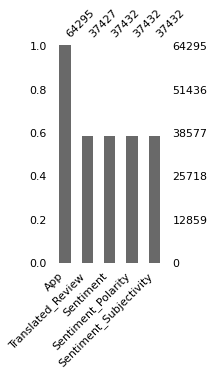

In [9]:
# missingno for features dataset, confirms the observations from previous cell
# ms.matrix(df_review)
msno.bar(df_review, figsize=(2, 4), fontsize=11)

## 3) Data Conversion and Feature Split
We rename columns as code friendly for easier access. We will convert the 'object' type columns into str or numeric to perform imputation later by splitting the columns with multiple meaningful contents into separate columns.

In [10]:
# rename columns to remove spaces
df_feature.columns = df_feature.columns.str.lower().str.replace(' ','_')
df_review.columns = df_review.columns.str.lower().str.replace(' ','_')

# show new column names
print("Feature:", end=" ")
print(*df_feature.columns.values, sep = ", ", end="\n")
print("Review:", end=" ")
print(*df_review.columns.values, sep = ", ", end="\n")

Feature: app, category, rating, reviews, size, installs, type, price, content_rating, genres, last_updated, current_ver, android_ver
Review: app, translated_review, sentiment, sentiment_polarity, sentiment_subjectivity


### 3.1) Feature Data

The columns **category**, **rating**, **type** were already available for further operations without any conversion or split with the exception of some erroneous lines which we have removed. We have worked on remaining columns of Feature data individually:

#### Category, Rating, Type:

In [11]:
# function to check floating numbers
def isfloat(string):
    try:
        if(not string==string):
            return False
        else:
            float(string)
            return True
    except ValueError:
        return False

# check if no elements of Category are numeric
category_sum = sum(list(map(lambda x: isfloat(x), df_feature.category)))

# check if no elements of Rating are nonnumeric
rating_sum = sum(list(map(lambda x: not isfloat(x) and (x==x), df_feature.rating)))

# check if no elements of Type are numeric
type_sum = sum(list(map(lambda x: isfloat(x), df_feature.type)))

print("Numeric entries in Category column:", category_sum)
print("Nonnumeric entries in Rating column:", rating_sum)
print("Numeric entries in Type column:", type_sum)

Numeric entries in Category column: 1
Nonnumeric entries in Rating column: 0
Numeric entries in Type column: 1


In [12]:
# show the errors in Category and Type columns
df_feature["out"] = list(map(lambda x: isfloat(x), df_feature.type)) or list(map(lambda x: isfloat(x), df_feature.category))

In [13]:
df_feature.iloc[np.where(df_feature.out)]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,out
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN,True


In [14]:
# remove the errors and the additional column
df_feature = df_feature.drop(df_feature.loc[np.where(df_feature.out)].index)
df_feature = df_feature.drop(columns=['out'])

In [15]:
# recheck the elements
category_sum = sum(list(map(lambda x: isfloat(x), df_feature.category)))
rating_sum = sum(list(map(lambda x: not isfloat(x) and (x==x), df_feature.rating)))
type_sum = sum(list(map(lambda x: isfloat(x), df_feature.type)))

print("Numeric entries in Category column:", category_sum)
print("Nonnumeric entries in Rating column:", rating_sum)
print("Numeric entries in Type column:", type_sum)

Numeric entries in Category column: 0
Nonnumeric entries in Rating column: 0
Numeric entries in Type column: 0


#### Reviews:

In [16]:
# convert to numeric by assigning errors as NaN
df_feature.reviews = df_feature.reviews.apply(pd.to_numeric, errors='coerce')

# recheck column info
df_feature.reviews.info()

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: reviews
Non-Null Count  Dtype
--------------  -----
10840 non-null  int64
dtypes: int64(1)
memory usage: 169.4 KB


#### Size:

In [17]:
# rename varying version with a shorter name
df_feature['size'] = df_feature['size'].str.replace(r"Varies with device", "Varies", regex=True)

# filter the rows except 'Varies' and remove the unit
df_feature.loc[df_feature['size'] != "Varies",'size'] = pd.to_numeric(df_feature.loc[df_feature['size'] != "Varies",'size'].replace(r"M", "", regex=True), errors='coerce')

# recheck column info
df_feature["size"].info()

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: size
Non-Null Count  Dtype 
--------------  ----- 
10524 non-null  object
dtypes: object(1)
memory usage: 169.4+ KB


In [18]:
df_feature.iloc[[1,1450,2144,10472]]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
1450,Real Estate sale & rent Trovit,HOUSE_AND_HOME,4.1,65913,7.7,"5,000,000+",Free,0,Everyone,House & Home,"July 16, 2018",4.47.3,4.0.3 and up
2144,Toddler Learning Games - Little Kids Games,FAMILY,4.2,731,Varies,"100,000+",Free,0,Everyone,Educational;Education,"July 28, 2018",3.7.2.7,4.2 and up
10473,osmino Wi-Fi: free WiFi,TOOLS,4.2,134203,4.1,"10,000,000+",Free,0,Everyone,Tools,"August 7, 2018",6.06.14,4.4 and up


#### Installs: 

In [19]:
# replace plus sign and comma with empty to remove it
df_feature.installs = pd.to_numeric(df_feature.installs.replace(('\+|,|'), '', regex=True), errors='coerce')

# recheck column info
df_feature.installs.info()

<class 'pandas.core.series.Series'>
Int64Index: 10840 entries, 0 to 10840
Series name: installs
Non-Null Count  Dtype
--------------  -----
10840 non-null  int64
dtypes: int64(1)
memory usage: 169.4 KB


#### Price:
All price information include a numeric value and the currency sign. Thus, we will remove the currency sign and set the price information as float.

In [20]:
# replace currency sign with empty to remove it
df_feature.price = pd.to_numeric(df_feature.price.str.replace(r"$", "", regex=True), errors='coerce')

# recheck the previous samples
df_feature.loc[475:477]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
475,KakaoTalk: Free Calls & Text,COMMUNICATION,4.3,2546527,Varies,100000000,Free,0.00,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
476,"Moco+ - Chat, Meet People",DATING,4.2,1545,Varies,10000,Paid,3.99,Mature 17+,Dating,"June 19, 2018",2.6.139,4.1 and up
477,Calculator,DATING,2.6,57,6.2,1000,Paid,6.99,Everyone,Dating,"October 25, 2017",1.1.6,4.0 and up


#### Content Rating:
Ref: https://www.esrb.org/ratings-guide/

In [21]:
# see unique content_rating types
df_feature.content_rating.unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [22]:
# find examples where it is "Unrated"
np.where(df_feature.content_rating.str.contains("Unrated"))

(array([7312, 8266], dtype=int64),)

In [23]:
# replace Unrated as missing (np.nan)
df_feature.content_rating.replace('Unrated', np.NaN, inplace=True)

# recheck the previous samples
df_feature.loc[7311:7313]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
7311,My CG,PRODUCTIVITY,NaN,0,Varies,10,Free,0.0,Teen,Productivity,"August 2, 2018",Varies with device,Varies with device
7312,Best CG Photography,FAMILY,NaN,1,2.5,500,Free,0.0,NaN,Entertainment,"June 24, 2015",5.2,3.0 and up
7313,BF CG View Wallpapers,FAMILY,3.6,13,2.5,1000,Free,0.0,Teen,Entertainment,"June 19, 2015",3.0,3.0 and up


In [24]:
# see unique content_rating types
df_feature.content_rating.unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', nan], dtype=object)

#### Genres:
Since the genre includes one or more categories, we will split the column to be able to use these categorical tags. 

In [25]:
# split genre tags as list items with delimeters ; and & and remove the items with comma (February 11, 2018)
df_feature.genres = df_feature.genres.apply(lambda x: list(filter(lambda y:re.findall(r'^[^,]+$', y), list(set(list(map(str.strip, x.replace('&',';').split(';'))))))))

# fix specific examples: "Editors", "Home" and "Educational"
df_feature.genres = df_feature.genres.apply(lambda x: list(set([y.replace('Editors', 'Video Editors').replace('Home','House').replace('Educational','Education') for y in x])))

# recheck the previous samples
df_feature.iloc[[1,1450,2144,10472]]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]","January 15, 2018",2.0.0,4.0.3 and up
1450,Real Estate sale & rent Trovit,HOUSE_AND_HOME,4.1,65913,7.7,5000000,Free,0.0,Everyone,[House],"July 16, 2018",4.47.3,4.0.3 and up
2144,Toddler Learning Games - Little Kids Games,FAMILY,4.2,731,Varies,100000,Free,0.0,Everyone,[Education],"July 28, 2018",3.7.2.7,4.2 and up
10473,osmino Wi-Fi: free WiFi,TOOLS,4.2,134203,4.1,10000000,Free,0.0,Everyone,[Tools],"August 7, 2018",6.06.14,4.4 and up


In [26]:
# unique tags are below, should ve also separate at & and remove similar ones (education:educational, house:home)
df_feature.genres.explode().unique()

array(['Design', 'Art', 'Pretend Play', 'Creativity', 'Adventure',
       'Action', 'Vehicles', 'Auto', 'Beauty', 'Books', 'Reference',
       'Business', 'Comics', 'Communication', 'Dating', 'Education',
       'Video', 'Music', 'Brain Games', 'Entertainment', 'Events',
       'Finance', 'Drink', 'Food', 'Health', 'Fitness', 'House',
       'Libraries', 'Demo', 'Lifestyle', 'Arcade', 'Casual', 'Card',
       'Strategy', 'Puzzle', 'Sports', 'Word', 'Racing', 'Simulation',
       'Board', 'Trivia', 'Role Playing', 'Audio', 'Video Players',
       'Video Editors', 'Medical', 'Social', 'Shopping', 'Photography',
       'Travel', 'Local', 'Tools', 'Personalization', 'Productivity',
       'Parenting', 'Weather', 'News', 'Magazines', 'Navigation', 'Maps',
       'Casino'], dtype=object)

#### Last Updated:

In [27]:
# transform not unique date string of the data into datetime form
df_feature.last_updated = pd.to_datetime(df_feature.last_updated, errors='coerce')

# extract the year in a new column 'update_year'
df_feature.insert(loc=(df_feature.columns.get_loc('last_updated')),
                        column='update_year', 
                        value=df_feature.last_updated.dt.year)

# extract the month in a new column 'update_month'
df_feature.insert(loc=(df_feature.columns.get_loc('last_updated')),
                        column='update_month', 
                        value=df_feature.last_updated.dt.month)

# extract the day in a new column 'update_day'
df_feature.insert(loc=(df_feature.columns.get_loc('last_updated')),
                        column='update_day', 
                        value=df_feature.last_updated.dt.day)

# extract the day name in a new column 'update_weekday'
df_feature.insert(loc=(df_feature.columns.get_loc('last_updated')),
                        column='update_weekday', 
                        value=df_feature.last_updated.dt.day_name())

# observe generated columns with datatime content (list of col vals to get the list of related column names)
df_feature.loc[:,list(df_feature.columns.values)[10:15]].head()

,update_year,update_month,update_day,update_weekday,last_updated
0,2018,1,7,Sunday,2018-01-07
1,2018,1,15,Monday,2018-01-15
2,2018,8,1,Wednesday,2018-08-01
3,2018,6,8,Friday,2018-06-08
4,2018,6,20,Wednesday,2018-06-20


#### Current Version:

In [28]:
# rename varying version with a shorter name
df_feature.current_ver = df_feature.current_ver.str.replace(r"Varies with device", "Varies", regex=True)

# set version string as version object (to be able to compare or sort later)
df_feature.current_ver = df_feature.current_ver.apply(lambda x: x if pd.isna(x) else parse(canonicalize_version(x)))

In [29]:
# recheck the previous samples
df_feature.loc[7311:7314]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
7311,My CG,PRODUCTIVITY,NaN,0,Varies,10,Free,0.0,Teen,[Productivity],2018,8,2,Thursday,2018-08-02,Varies,Varies with device
7312,Best CG Photography,FAMILY,NaN,1,2.5,500,Free,0.0,NaN,[Entertainment],2015,6,24,Wednesday,2015-06-24,5.2,3.0 and up
7313,BF CG View Wallpapers,FAMILY,3.6,13,2.5,1000,Free,0.0,Teen,[Entertainment],2015,6,19,Friday,2015-06-19,3,3.0 and up
7314,CG Sanyukt Bharti Pariksha 2018,FAMILY,4.3,14,4.3,1000,Free,0.0,Teen,[Education],2018,1,10,Wednesday,2018-01-10,7.4,2.3 and up


#### Android Version:

In [30]:
# rename varying version with a shorter name
df_feature.android_ver = df_feature.android_ver.str.replace(r"Varies with device", "Varies", regex=True)

# crop "and up" from version number
df_feature.android_ver = df_feature.android_ver.str.split("and up", expand=True)[0]

# set version string as version object (to be able to compare or sort later)
df_feature.android_ver = df_feature.android_ver.apply(lambda x: x if pd.isna(x) else parse(canonicalize_version(x)))

In [31]:
# recheck the previous samples
df_feature.loc[7311:7314]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
7311,My CG,PRODUCTIVITY,NaN,0,Varies,10,Free,0.0,Teen,[Productivity],2018,8,2,Thursday,2018-08-02,Varies,Varies
7312,Best CG Photography,FAMILY,NaN,1,2.5,500,Free,0.0,NaN,[Entertainment],2015,6,24,Wednesday,2015-06-24,5.2,3
7313,BF CG View Wallpapers,FAMILY,3.6,13,2.5,1000,Free,0.0,Teen,[Entertainment],2015,6,19,Friday,2015-06-19,3,3
7314,CG Sanyukt Bharti Pariksha 2018,FAMILY,4.3,14,4.3,1000,Free,0.0,Teen,[Education],2018,1,10,Wednesday,2018-01-10,7.4,2.3


### 3.2) Review Data
All Review set columns were already available for further operations without any conversion or split. So we did not perform any column specific operation here. 

**NOTE:** *The sentiment function of textblob returns two properties, polarity, and subjectivity.*
*Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].*

## 4) Data Imputation
We check the initial empty cell rates per column within the data frame for further operations.

<AxesSubplot:>

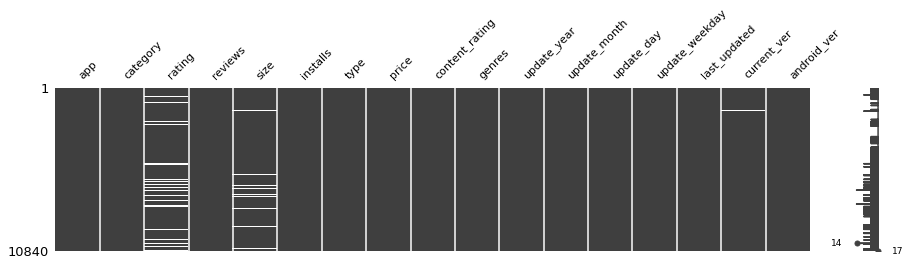

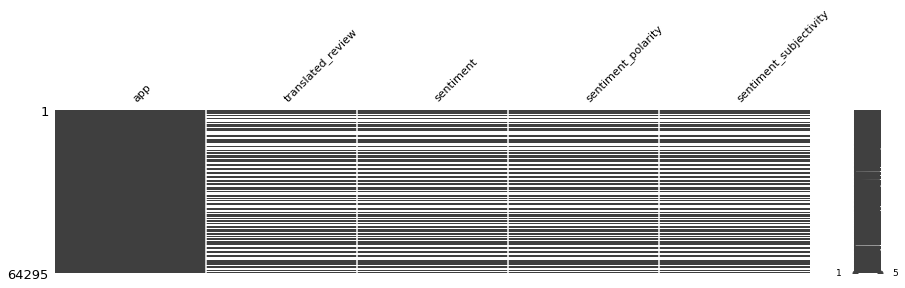

In [32]:
# using missingno library to review missing values
msno.matrix(df_feature, figsize=(15, 3), fontsize=11)
msno.matrix(df_review, figsize=(15, 3), fontsize=11)

In [33]:
# Additional plotting to see missing value percentage by columns
# TODO: parametrize the text alignment and graph colors
def findEmpty(df):
    percentages = []
    labels = []
    str_ = ""

    # iterate over data
    for col in df.columns:
        # percentage of null cells in the whole column
        p_missing = np.mean(df[col].isnull())
        # sum of null cells in the whole column
        missing = df[col].isnull().sum()
        percentages.append(p_missing*100)
        labels.append(col)
        # generate a string to print out results with numbers
        if(missing):
            str_ += "\n" + col + " - " + str(missing) + " / " + str(len(df[col]))
    return percentages, labels, str_

def plotEmpty(names, *dfs):
    # common plot calls
    text_kwargs = dict(ha='left', va='top', fontsize=11)
    plt.figure(num=None, figsize=(len(dfs)*6, 4))
    
    # color list to change color on each graph
    colors = ['skyblue','teal','pink','turquoise','maroon','navyblue']
    
    for idx, df in enumerate(dfs):
        percentages, labels, str_ = findEmpty(df)
        
        # plot results with bar plot
        ticks = list(range(1, len(labels)+1))
        plt.subplot(1, len(dfs), idx+1)
        plt.bar(ticks, percentages, color=colors[idx])
        plt.xticks(ticks, labels, rotation=75)
        plt.ylim(0, 120)
        plt.text(0.5, 125, str_, **text_kwargs)
        for index, value in enumerate(percentages):
            plt.text(index+1, value, str(int(value)), ha='center', va='bottom')
        plt.ylabel('Percentages')
        plt.title(names[idx]+' Empty Cell Percentages')
        
    plt.show()

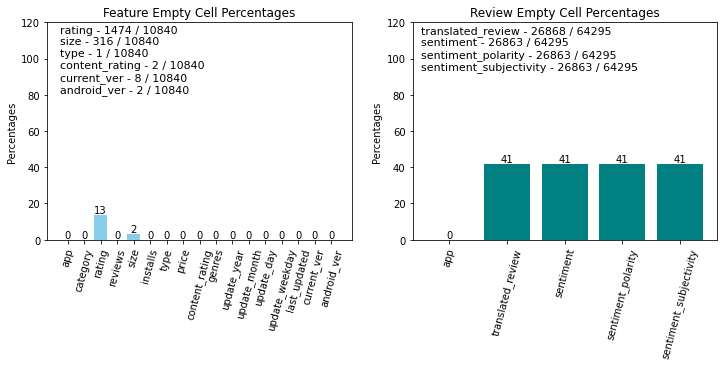

In [34]:
# plot empty columns of datasets
plotEmpty(["Feature", "Review"], df_feature, df_review)

Here we see that some columns of Features set have very few numbers of missing entries. For those, we will drop the rows with missing entries. For larger amount of missing entries (or not missing but unusual values as in "Varies") we will apply individual solutions.

In [35]:
# drop rows with nan values in price, content_rating, last_updated, current_ver, android_ver 
nan_cols = df_feature.reviews.isnull() | df_feature.installs.isnull() | df_feature["type"].isnull() | df_feature.price.isnull() | df_feature.content_rating.isnull() | df_feature.last_updated.isnull() | df_feature.current_ver.isnull() | df_feature.android_ver.isnull()
df_feature.drop(df_feature[nan_cols].index, inplace=True)

<AxesSubplot:>

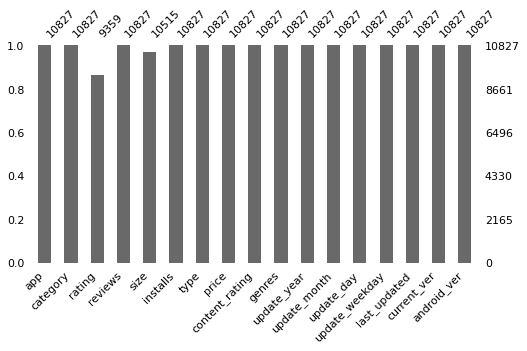

In [36]:
# check missing values
msno.bar(df_feature, figsize=(8, 4), fontsize=11)

For reviews, if a row misses translated_review we will drop the row sice the sentiment analysis is invalid without a text.

<AxesSubplot:>

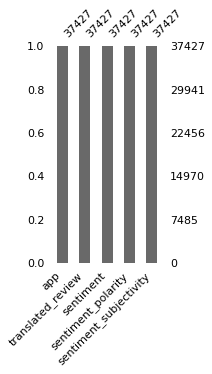

In [37]:
# drop rows with nan values in sentiment, sentiment_polarity and sentiment_subjectivity 
df_review.dropna(subset=['translated_review'], inplace=True)

# check missing values
msno.bar(df_review, figsize=(2, 4), fontsize=11)

After dropping the empty rows, we may now fill NaN values with column specific solutions. There is only rating column which require some imputation.

### 4.1) Feature Data

In [38]:
# check some sample row locations for empty cells to view: np.where(df_feature.isnull())
# df_feature.iloc[np.unique(np.where(df_feature.isnull())[0])].head(3) # only rating is missing

# print some interval with empties to check the imputation results later
df_feature.loc[123:126]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
123,Manicure - nail design,BEAUTY,NaN,119,3.7,50000,Free,0.0,Everyone,[Beauty],2018,7,23,Monday,2018-07-23,1.3,4.1
124,"Sticker Camera - Selfie Filters, Beauty Camera",BEAUTY,3.9,2277,22.0,500000,Free,0.0,Everyone,[Beauty],2018,7,12,Thursday,2018-07-12,1.1,4.0.3
125,Filters for B Live,BEAUTY,4.4,2280,24.0,500000,Free,0.0,Everyone,[Beauty],2018,5,14,Monday,2018-05-14,1.1,4
126,Skin Care and Natural Beauty,BEAUTY,NaN,654,7.4,100000,Free,0.0,Teen,[Beauty],2018,7,17,Tuesday,2018-07-17,1.15,4.1


#### Rating:

To fill the missing rating values, we will group by category and type to get average and assign it to the same category and type missing samples.

In [39]:
# category and type averages
filtered_avg = (df_feature.groupby(['category','type']).rating.mean()).to_dict()

# sample dictionary items
dict(islice(filtered_avg.items(), 0, 4))

{('ART_AND_DESIGN', 'Free'): 4.358620689655172,
 ('ART_AND_DESIGN', 'Paid'): 4.733333333333333,
 ('AUTO_AND_VEHICLES', 'Free'): 4.184722222222223,
 ('AUTO_AND_VEHICLES', 'Paid'): 4.6}

In [40]:
# create a series from matching dictionary items
series_avg = pd.Series([filtered_avg[x] for x in list(zip(df_feature.category, df_feature['type']))])

# assign each rating entry with NaN value using the series
df_feature.rating = df_feature.rating.fillna(series_avg)

# drop remaining missings (~3 samples which were below average)
df_feature.drop(df_feature[df_feature.rating.isnull()].index, inplace=True)

# recheck the previous samples
df_feature.loc[123:126]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
123,Manicure - nail design,BEAUTY,4.278571,119,3.7,50000,Free,0.0,Everyone,[Beauty],2018,7,23,Monday,2018-07-23,1.3,4.1
124,"Sticker Camera - Selfie Filters, Beauty Camera",BEAUTY,3.900000,2277,22.0,500000,Free,0.0,Everyone,[Beauty],2018,7,12,Thursday,2018-07-12,1.1,4.0.3
125,Filters for B Live,BEAUTY,4.400000,2280,24.0,500000,Free,0.0,Everyone,[Beauty],2018,5,14,Monday,2018-05-14,1.1,4
126,Skin Care and Natural Beauty,BEAUTY,4.278571,654,7.4,100000,Free,0.0,Teen,[Beauty],2018,7,17,Tuesday,2018-07-17,1.15,4.1


#### Size:

Since the missing entires in size are much larger, we will first review highest rated and most downloaded samples to decide dropping or imputing. Below we see that there are somevery important samples, thus we will impute the missing size entries as "Varies".

In [41]:
# review highest rated and most downloaded samples
df_feature.iloc[np.where(df_feature["size"].isna())].sort_values(by=['installs','rating'], ascending=False).head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,update_year,update_month,update_day,update_weekday,last_updated,current_ver,android_ver
7223,Terminal Emulator for Android,TOOLS,4.4,113951,NaN,10000000,Free,0.0,Everyone,[Tools],2015,4,15,Wednesday,2015-04-15,1.0.70,1.6
458,GO Notifier,COMMUNICATION,4.2,124346,NaN,10000000,Free,0.0,Everyone,[Communication],2014,7,6,Sunday,2014-07-06,2.8,2
3350,Screen Off and Lock,TOOLS,4.1,172990,NaN,10000000,Free,0.0,Everyone,[Tools],2017,12,2,Saturday,2017-12-02,1.17.4,2.2
3418,Galactic Core Free Wallpaper,PERSONALIZATION,4.1,69417,NaN,10000000,Free,0.0,Everyone,[Personalization],2014,5,1,Thursday,2014-05-01,2.41,2.1
8312,Satellite Director,TOOLS,4.1,45610,NaN,10000000,Free,0.0,Everyone,[Tools],2018,1,2,Tuesday,2018-01-02,1.56,1.6


In [42]:
# impute missing size as varies
df_feature["size"] = df_feature["size"].fillna("Varies")

After completing the imputation, we will check for the remaining empty cells.

In [43]:
# check if there are any empty entries left
print("Feature:", df_feature.isnull().values.sum(), "empty entries.")
print("Review:", df_review.isnull().values.sum(), "empty entries.")

Feature: 0 empty entries.
Review: 0 empty entries.


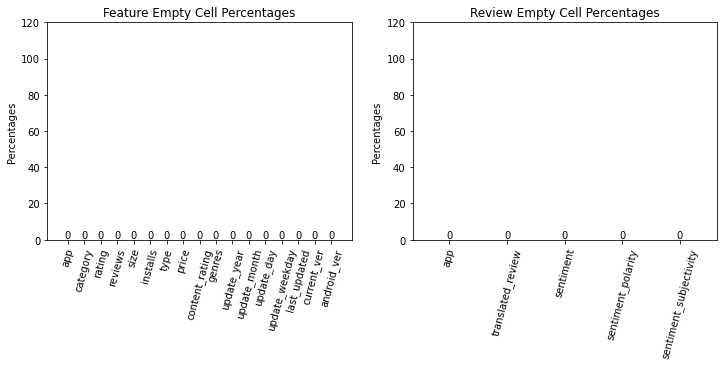

In [44]:
# check if there are any empty entries left
plotEmpty(["Feature", "Review"], df_feature, df_review)

In [45]:
# create a function for side by side printing of dataframes
def print_stacked(names, *dfs):
    stacked = ""
    for idx, df in enumerate(dfs):
        stacked += df.style.set_table_attributes("style='display:inline'").set_caption(names[idx])._repr_html_() + "&nbsp;"*10
    display_html(stacked, raw=True)

# selected columns for Feature set
sel_col = ["rating", "reviews", "size", "installs", "price"]

# observe numerical columns description of both tables
print_stacked(["Feature", "Review"], df_feature[sel_col].describe(), df_review.describe())

Feature 
 
 
   
 rating 
 reviews 
 installs 
 price 
 
 
 
 
 count 
 10824.000000 
 10824.000000 
 10824.000000 
 10824.000000 
 
 
 mean 
 4.190556 
 444807.031042 
 15487047.290004 
 1.028566 
 
 
 std 
 0.480571 
 2929874.424682 
 85090135.364509 
 15.961448 
 
 
 min 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 
 
 25% 
 4.035575 
 38.000000 
 5000.000000 
 0.000000 
 
 
 50% 
 4.279804 
 2106.000000 
 100000.000000 
 0.000000 
 
 
 75% 
 4.500000 
 55011.750000 
 5000000.000000 
 0.000000 
 
 
 max 
 5.000000 
 78158306.000000 
 1000000000.000000 
 400.000000 
 
 
 
          
 
 Review 
 
 
   
 sentiment_polarity 
 sentiment_subjectivity 
 
 
 
 
 count 
 37427.000000 
 37427.000000 
 
 
 mean 
 0.182171 
 0.492770 
 
 
 std 
 0.351318 
 0.259904 
 
 
 min 
 -1.000000 
 0.000000 
 
 
 25% 
 0.000000 
 0.357143 
 
 
 50% 
 0.150000 
 0.514286 
 
 
 75% 
 0.400000 
 0.650000 
 
 
 max 
 1.000000 
 1.000000

## 6) Join Data (& drop duplicates)

The data sets **Feature** and **Review** include different information for common apps. Thus, we will match the titles for existing entries in both sets and obtain a final set with all the combined information.

In [46]:
# check for duplicated entries in Feature set
print("Initially duplicated entries in Feature set:", df_feature.duplicated(subset=['app']).sum())

# drop duplicates of app in case any
df_feature = df_feature.drop_duplicates(subset=['app'])
unique_apps_f = df_feature['app'].tolist()

# check for duplicated entries
print("Remaining duplicated entries in Feature set:", df_feature.duplicated(subset=['app']).sum())

Initially duplicated entries in Feature set: 1181
Remaining duplicated entries in Feature set: 0


In [47]:
# check for duplicated entries in Review set
print("Initially duplicated entries in Review set:", df_review.duplicated().sum())

# drop duplicates of titles in case any
df_review = df_review.drop_duplicates()
unique_apps_r = df_review['app'].tolist()

# check for duplicated entries
print("Remaining duplicated entries in Review set:", df_review.duplicated().sum())

Initially duplicated entries in Review set: 7735
Remaining duplicated entries in Review set: 0


In [48]:
# get a list of intersecting apps
matches = list(set(unique_apps_f) & set(unique_apps_r))

print("Unique app names with feature:",len(set(unique_apps_f)),\
      "\nUnique app names with review:", len(set(unique_apps_r)),\
      "\nMatching unique apps with features and reviews",len(matches))

Unique app names with feature: 9643 
Unique app names with review: 865 
Matching unique apps with features and reviews 816


In [49]:
# filter dataframes for only matching apps
df_f_part = df_feature[df_feature.app.isin(list(matches))]
df_r_part = df_review[df_review.app.isin(list(matches))]

##### Merge 1: OUTER (keep repeated rows of features)

In [50]:
# MERGE TYPE 1: OUTER MERGE (keep repeated rows of features)
result_outer = pd.merge(df_f_part, df_r_part, how="outer", on=["app", "app"])
result_outer.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,...,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,A kid's excessive ads. The types ads allowed a...,Negative,-0.250,1.000000
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,It bad >:(,Negative,-0.725,0.833333
2,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,like,Neutral,0.000,0.000000
3,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,I love colors inspyering,Positive,0.500,0.600000
4,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,I hate,Negative,-0.800,0.900000


##### Merge 2: AVERAGE (keep average of review sentiment columns)

In [51]:
# MERGE TYPE 2: AVERAGE MERGE (keep average of review sentiment columns)
# groupby reviews on app name by taking average of numeric columns
df_r_part_avg = df_r_part.groupby("app", as_index=False).mean()

# insert sentiment by average polarity as new column
df_r_part_avg.insert(loc=(df_r_part_avg.columns.get_loc('sentiment_polarity')),\
                     column='sentiment',\
                     value=(np.where(df_r_part_avg.sentiment_polarity > 0,"Positive",\
                                     np.where(df_r_part_avg.sentiment_polarity < 0, "Negative", "Neutral"))))

# insert review count per app as new column
df_r_part_avg.insert(loc=(df_r_part_avg.columns.get_loc('sentiment')),\
                     column='review_count',\
                     value=(df_r_part.value_counts(subset=['app'], sort=False).values))

# observe the averaged results for reviews
df_r_part_avg.head()

,app,review_count,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,95,Positive,0.465906,0.493254
1,11st,39,Positive,0.185943,0.455340
2,1800 Contacts - Lens Store,40,Positive,0.318145,0.591098
3,1LINE – One Line with One Touch,38,Positive,0.196290,0.557315
4,2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,29,Positive,0.423659,0.512356


In [52]:
# merge tables with inner to keep intersection
result_avg = pd.merge(df_f_part, df_r_part_avg, how="inner", on=["app", "app"])
result_avg.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,...,update_month,update_day,update_weekday,last_updated,current_ver,android_ver,review_count,sentiment,sentiment_polarity,sentiment_subjectivity
0,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,"[Art, Pretend Play, Design]",...,1,15,Monday,2018-01-15,2,4.0.3,20,Positive,0.117917,0.645694
1,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33.0,1000000,Free,0.0,Everyone,"[Design, Art]",...,9,20,Wednesday,2017-09-20,2.9.2,3,90,Positive,0.268483,0.523447
2,FlipaClip - Cartoon animation,ART_AND_DESIGN,4.3,194216,39.0,5000000,Free,0.0,Everyone,"[Design, Art]",...,8,3,Friday,2018-08-03,2.2.5,4.0.3,4,Positive,0.412649,0.679226
3,Boys Photo Editor - Six Pack & Men's Suit,ART_AND_DESIGN,4.1,654,12.0,100000,Free,0.0,Everyone,"[Design, Art]",...,3,20,Tuesday,2018-03-20,1.1,4.0.3,36,Positive,0.260370,0.472593
4,Colorfit - Drawing & Coloring,ART_AND_DESIGN,4.7,20260,25.0,500000,Free,0.0,Everyone,"[Design, Art, Creativity]",...,10,11,Wednesday,2017-10-11,1.0.8,4.0.3,38,Positive,0.171836,0.572762


In [53]:
# store variables for dataframes in the IPython databaseto start analysis on a clear notebook
%store df_feature
%store df_review
%store result_outer
%store result_avg

Stored 'df_feature' (DataFrame)
Stored 'df_review' (DataFrame)
Stored 'result_outer' (DataFrame)
Stored 'result_avg' (DataFrame)


In [54]:
# save raw data for emergency uses
if not os.path.exists('data'):
    os.mkdir('data')
df_feature.to_csv(os.path.join('data', 'raw_feature.csv'), encoding='utf-8-sig')
df_review.to_csv(os.path.join('data', 'raw_review.csv'), encoding='utf-8-sig')
result_outer.to_csv(os.path.join('data', 'raw_outer_merge.csv'), encoding='utf-8-sig')
result_avg.to_csv(os.path.join('data', 'raw_avg_merge.csv'), encoding='utf-8-sig')